# Earthquake Bot — Profit Chart

**Формула:** `profit = (invested_in_positions + free_balance) - total_deposits`

Эти значения не прыгают от текущих цен — только от реальных сделок (buy/sell/resolution).

In [1]:
# Синхронизация данных с сервера
import subprocess, platform, os

SERVER = 'root@62.112.10.73'
REMOTE = '/opt/polymarket/earthquakes/trading_bot/data'

# Определяем WSL-путь к локальной папке data
if platform.system() == 'Windows':
    win_cwd = os.getcwd().replace('\\', '/')
    local_base = '/mnt/' + win_cwd[0].lower() + win_cwd[2:] + '/trading_bot/data'
else:
    local_base = os.path.abspath('trading_bot/data')

cmd = (
    f'rsync -az --delete {SERVER}:{REMOTE}/active/ {local_base}/active/ && '
    f'rsync -az {SERVER}:{REMOTE}/history/ {local_base}/history/'
)

if platform.system() == 'Windows':
    r = subprocess.run(['wsl', 'bash', '-c', cmd], capture_output=True, text=True, timeout=30)
else:
    r = subprocess.run(['bash', '-c', cmd], capture_output=True, text=True, timeout=30)

if r.returncode == 0:
    print('Synced from server')
else:
    err = (r.stderr or '').strip()[:200]
    print(f'Sync failed (rc={r.returncode}), using local data. {err}')

Synced from server


In [2]:
import json
from pathlib import Path
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

DATA_DIR = Path('trading_bot/data')

def load_positions(directory):
    positions = []
    for f in directory.glob('*.json'):
        positions.append(json.loads(f.read_text()))
    return positions

active = load_positions(DATA_DIR / 'active')
closed = load_positions(DATA_DIR / 'history')
all_pos = active + closed

print(f'Active: {len(active)}, Closed: {len(closed)}, Total: {len(all_pos)}')

Active: 10, Closed: 84, Total: 94


In [3]:
# Получить текущий баланс USDC.e с блокчейна
import urllib.request

WALLET = '0xff36fc6De4CCDd290C14EE69244c21c1803Ad5b7'
USDC_E = '0x2791Bca1f2de4661ED88A30C99A7a9449Aa84174'

# balanceOf(address) call
selector = '0x70a08231'
padded = WALLET[2:].lower().zfill(64)
call_data = selector + padded

RPCS = ['https://polygon-rpc.com', 'https://polygon-bor-rpc.publicnode.com', 'https://rpc.ankr.com/polygon']

current_balance = None
for rpc in RPCS:
    try:
        payload = json.dumps({
            'jsonrpc': '2.0', 'id': 1, 'method': 'eth_call',
            'params': [{'to': USDC_E, 'data': call_data}, 'latest']
        }).encode()
        req = urllib.request.Request(rpc, data=payload,
                                     headers={'Content-Type': 'application/json', 'User-Agent': 'Mozilla/5.0'})
        resp = json.loads(urllib.request.urlopen(req, timeout=10).read())
        current_balance = int(resp['result'], 16) / 1e6
        print(f'USDC.e balance: ${current_balance:.2f}  (via {rpc.split("//")[1].split("/")[0]})')
        break
    except Exception as e:
        print(f'{rpc}: {e}')

if current_balance is None:
    raise RuntimeError('Cannot fetch balance from any RPC')

USDC.e balance: $1000.78  (via polygon-rpc.com)


In [4]:
# Вычислить общую сумму депозитов:
# deposits = balance + invested_now - realized_pnl

invested_now = sum(p['entry_size'] for p in active)
realized_pnl = sum((p.get('exit_size') or 0) - p['entry_size'] for p in closed)

total_deposits = current_balance + invested_now - realized_pnl

print(f'Free balance:     ${current_balance:>10.2f}')
print(f'Invested (active):${invested_now:>10.2f}')
print(f'Realized P&L:     ${realized_pnl:>+10.2f}')
print(f'─────────────────────────────')
print(f'Total deposits:   ${total_deposits:>10.2f}')
print(f'Total capital:    ${current_balance + invested_now:>10.2f}')
print(f'Profit:           ${current_balance + invested_now - total_deposits:>+10.2f}')

Free balance:     $   1000.78
Invested (active):$   1167.16
Realized P&L:     $    +84.43
─────────────────────────────
Total deposits:   $   2083.51
Total capital:    $   2167.94
Profit:           $    +84.43


In [5]:
# Построить временную линию событий
# Каждое событие: buy (invested ↑, balance ↓) или sell (invested ↓, balance ↑)

def parse_dt(s):
    s = s.replace('Z', '+00:00')
    return datetime.fromisoformat(s)

events = []

for p in all_pos:
    # Buy event
    events.append({
        'time': parse_dt(p['entry_time']),
        'type': 'buy',
        'amount': p['entry_size'],  # cash out, invested in
        'id': p['id'],
    })
    # Sell/close event (only for closed positions)
    if p.get('exit_time'):
        events.append({
            'time': parse_dt(p['exit_time']),
            'type': 'sell',
            'amount_out': p['entry_size'],   # invested out
            'amount_in': p.get('exit_size') or 0,  # cash in
            'pnl': (p.get('exit_size') or 0) - p['entry_size'],
            'id': p['id'],
        })

events.sort(key=lambda e: e['time'])

# Реконструкция: balance + invested в каждый момент
# Начало: balance = deposits, invested = 0
times = [events[0]['time'] - __import__('datetime').timedelta(hours=1)]  # точка до первого трейда
invested_hist = [0.0]
balance_hist = [total_deposits]
profit_hist = [0.0]

bal = total_deposits
inv = 0.0

for e in events:
    if e['type'] == 'buy':
        bal -= e['amount']
        inv += e['amount']
    else:  # sell
        inv -= e['amount_out']
        bal += e['amount_in']

    times.append(e['time'])
    invested_hist.append(inv)
    balance_hist.append(bal)
    profit_hist.append(bal + inv - total_deposits)

print(f'Events: {len(events)} ({sum(1 for e in events if e["type"]=="buy")} buys, {sum(1 for e in events if e["type"]=="sell")} sells)')
print(f'Period: {times[1].strftime("%Y-%m-%d %H:%M")} → {times[-1].strftime("%Y-%m-%d %H:%M")}')

Events: 178 (94 buys, 84 sells)
Period: 2026-02-01 07:15 → 2026-02-14 15:26


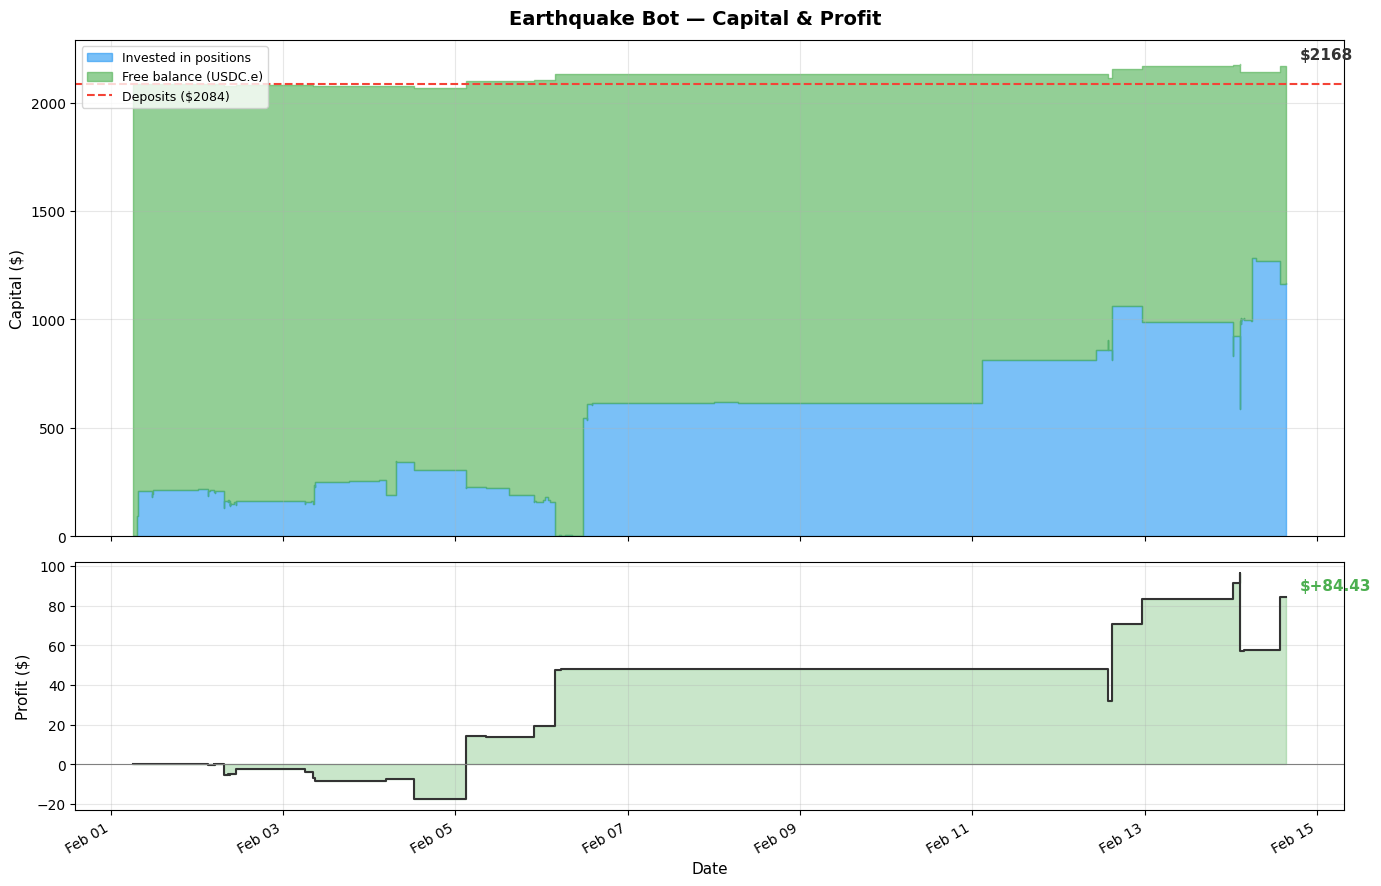


Deposits: $2083.51  |  Capital: $2167.94  |  Profit: $+84.43 (+4.1%)


In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
fig.suptitle('Earthquake Bot — Capital & Profit', fontsize=14, fontweight='bold')

# === Top: Stacked area (invested + balance) ===
ax1.fill_between(times, 0, invested_hist, alpha=0.6, color='#2196F3', label='Invested in positions', step='post')
ax1.fill_between(times, invested_hist, [i+b for i,b in zip(invested_hist, balance_hist)],
                 alpha=0.6, color='#4CAF50', label='Free balance (USDC.e)', step='post')
ax1.axhline(y=total_deposits, color='#F44336', linestyle='--', linewidth=1.5, label=f'Deposits (${total_deposits:.0f})')

# Текущие значения
total_now = invested_hist[-1] + balance_hist[-1]
ax1.annotate(f'${total_now:.0f}', xy=(times[-1], total_now), fontsize=11, fontweight='bold',
             xytext=(10, 5), textcoords='offset points', color='#333')

ax1.set_ylabel('Capital ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# === Bottom: Profit line ===
colors = ['#4CAF50' if p >= 0 else '#F44336' for p in profit_hist]
ax2.fill_between(times, 0, profit_hist, alpha=0.3,
                 color='#4CAF50' if profit_hist[-1] >= 0 else '#F44336', step='post')
ax2.step(times, profit_hist, where='post', color='#333', linewidth=1.5)
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.8)

# Аннотация текущего профита
pnl_now = profit_hist[-1]
ax2.annotate(f'${pnl_now:+.2f}', xy=(times[-1], pnl_now), fontsize=11, fontweight='bold',
             xytext=(10, 5), textcoords='offset points',
             color='#4CAF50' if pnl_now >= 0 else '#F44336')

ax2.set_ylabel('Profit ($)', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

print(f'\nDeposits: ${total_deposits:.2f}  |  Capital: ${total_now:.2f}  |  Profit: ${pnl_now:+.2f} ({pnl_now/total_deposits*100:+.1f}%)')

In [7]:
# Детализация: P&L по дням
from collections import defaultdict

daily_pnl = defaultdict(float)
daily_trades = defaultdict(int)
daily_volume = defaultdict(float)

for e in events:
    day = e['time'].strftime('%Y-%m-%d')
    if e['type'] == 'sell':
        daily_pnl[day] += e['pnl']
        daily_trades[day] += 1
    if e['type'] == 'buy':
        daily_volume[day] += e['amount']

all_days = sorted(set(list(daily_pnl.keys()) + list(daily_volume.keys())))

print(f'{"Day":<12} {"Sells":>5} {"P&L":>8} {"Volume":>8} {"Cum P&L":>8}')
print('─' * 45)
cum = 0
for day in all_days:
    pnl = daily_pnl.get(day, 0)
    cum += pnl
    trades = daily_trades.get(day, 0)
    vol = daily_volume.get(day, 0)
    print(f'{day}  {trades:>5}  ${pnl:>+7.2f}  ${vol:>7.2f}  ${cum:>+7.2f}')

Day          Sells      P&L   Volume  Cum P&L
─────────────────────────────────────────────
2026-02-01      2  $  +0.30  $ 239.54  $  +0.30
2026-02-02     21  $  -2.77  $ 131.82  $  -2.46
2026-02-03      9  $  -5.76  $ 126.02  $  -8.22
2026-02-04      8  $  -9.26  $ 159.85  $ -17.48
2026-02-05     16  $ +36.64  $  10.19  $ +19.16
2026-02-06      8  $ +29.08  $ 658.62  $ +48.24
2026-02-08      1  $  -0.31  $   1.29  $ +47.93
2026-02-11      0  $  +0.00  $ 197.96  $ +47.93
2026-02-12      6  $ +35.42  $ 336.42  $ +83.36
2026-02-14     13  $  +1.08  $ 828.50  $ +84.43
